In [119]:
"""
This file is used to visualize transcriptomic data for Daphnia magna.

1.  Violin plots and Boxplots
    Read counts are cleaned so only expression values are in the dataframe and timepoints are deleted.
    Re-format data so expression levels are in one column and condition labels are in another.
    Visualize data in violin plots and boxplots to ensure a normal distribution and prepare for further analysis

2.  Lineplots
    Re-format data so it has dose, expression value and timepoints in 3 columns
    Visualize data in lineplots for one gene to see expression changes over time

3.  PCA plot
    Use 2 principal components and color by condition to see clusters
    Use 2 principal components and color by timepoints to see clusters
    
"""

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA

In [35]:
lipids = pd.read_csv('omics/lipids_neg_glog_proc.csv')
polar_neg = pd.read_csv('omics/polar_neg_glog_proc.csv')
polar_pos = pd.read_csv('omics/polar_pos_glog_proc.csv')
genes = pd.read_csv('omics/rna_vst_proc.csv')
reproduction = pd.read_csv('phenotypic/mean_cumulative_reproduction.csv')
neonates = pd.read_csv('phenotypic/mean_total_neonates.csv')

/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_61926/4051946843.py:4: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160) have mixed types. Specify dtype option on import or set low_memory=False.
  genes = pd.read_csv('omics/rna_vst_proc.csv')


In [160]:
#process transcriptomic data for histogram, creates a df without first two rows
genes_dropped = genes.drop([0,1], axis=0)
#creates a df without first two rows and without first two columns (i.e. only gene expression data)
genes_dropped_again = genes_dropped.drop(['Unnamed: 0','treatment'], axis=1)

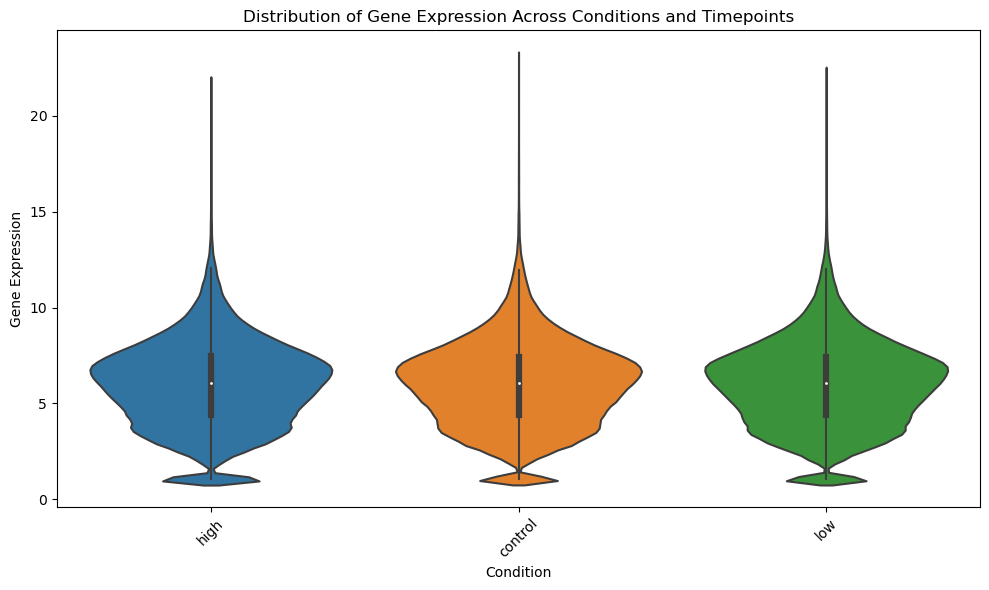

In [162]:
# Extract condition names from column names
conditions = set(column.split('.')[0] for column in genes_dropped_again.columns if column != 'Unnamed: 0' and column != 'treatment')

# Create a list to store data for each condition
data_by_condition = []

# Iterate over condition names and extract data for each condition
for condition in conditions:
    condition_data = genes_dropped_again[[column for column in genes_dropped_again.columns if column.startswith(condition)]]
    # Remove the prefix from column names
    condition_data = condition_data.rename(columns=lambda x: x.split('.')[1] if '.' in x else x)  
    condition_data = condition_data.melt(var_name='Timepoint', value_name='Expression')
    condition_data['Condition'] = condition
    data_by_condition.append(condition_data)

# Concatenate data for all conditions into a single DataFrame - has columns expression and condition
combined_data = pd.concat(data_by_condition)

#turn all values into float values and add to dataframe
expression_list = combined_data['Expression'].tolist()
new_expression = []

for expression in expression_list:
    expression_int = float(expression)
    new_expression.append(expression_int)

combined_data['E_levels'] = new_expression
combined_data.head()

# Create violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Condition', y='E_levels', data=combined_data, split=True)
plt.title('Distribution of Gene Expression Across Conditions and Timepoints')
plt.xlabel('Condition')
plt.ylabel('Gene Expression')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

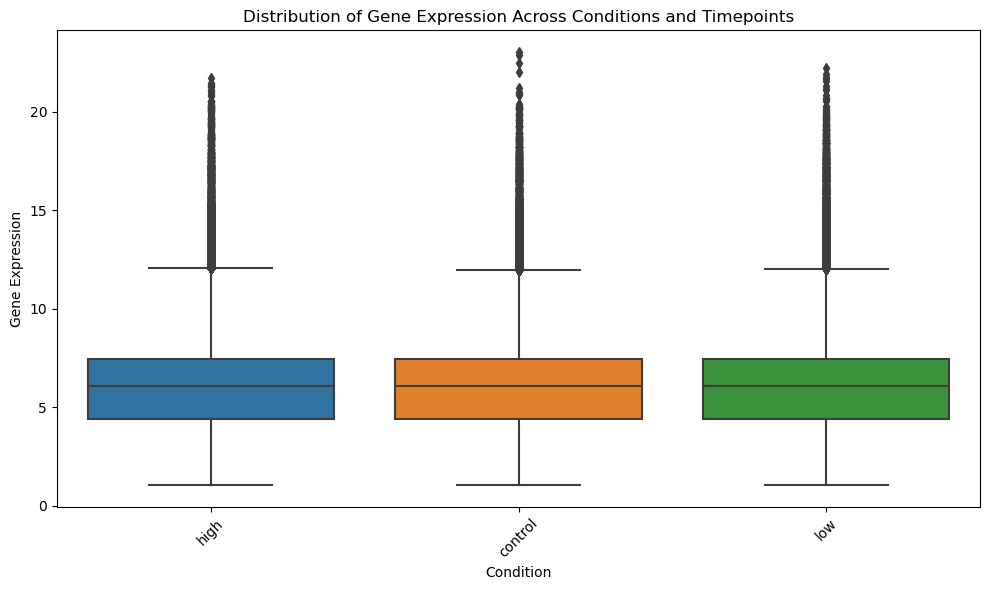

In [84]:
#create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Condition', y='E_levels',data=combined_data)
plt.title('Distribution of Gene Expression Across Conditions and Timepoints')
plt.xlabel('Condition')
plt.ylabel('Gene Expression')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Gene Expression Over Time for Dapma7bEVm010988')

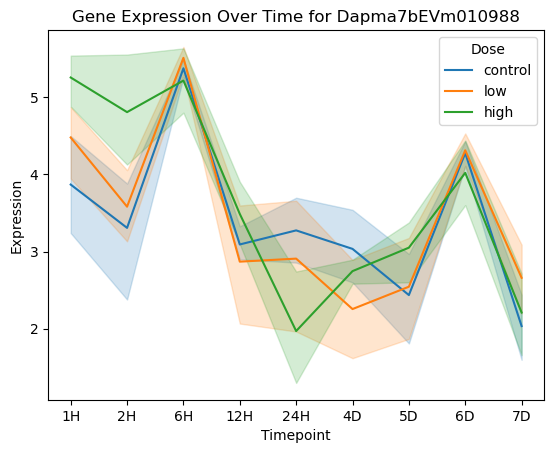

In [158]:
# Extract timepoints from the first row, starting from the third column
timepoints = list(genes.iloc[0, 2:])

#make a list of columns, list of genes
doses = list(genes.columns[2:])
gene_exp = list(genes.iloc[10000, 2:])

#make doses to just control, low, high separated by timepoint
new_doses = []

# Compile the regex pattern
pattern_control = re.compile(r'^[c]')
pattern_low = re.compile(r'^[l]')
pattern_high = re.compile(r'^[h]')

# Filter strings that match the pattern
for dose in doses:
    if pattern_control.match(dose):
        new_doses.append('control')
    elif pattern_low.match(dose):
        new_doses.append('low')
    else:
        new_doses.append('high')

#add to a new dataframe, with dose, timepoint, and expression columns
column_names = ['Dose', 'Timepoint', 'Expression']
lineplot_data = pd.DataFrame({
    column_names[0]: new_doses,
    column_names[1]: timepoints,
    column_names[2]: gene_exp
})

#plot lineplot with timepoints on x axis, gene expression on y axis, hue is dose
lineplot = sns.lineplot(data=lineplot_data,x='Timepoint',y='Expression',hue='Dose')
lineplot.set_title('Gene Expression Over Time for Dapma7bEVm010988')


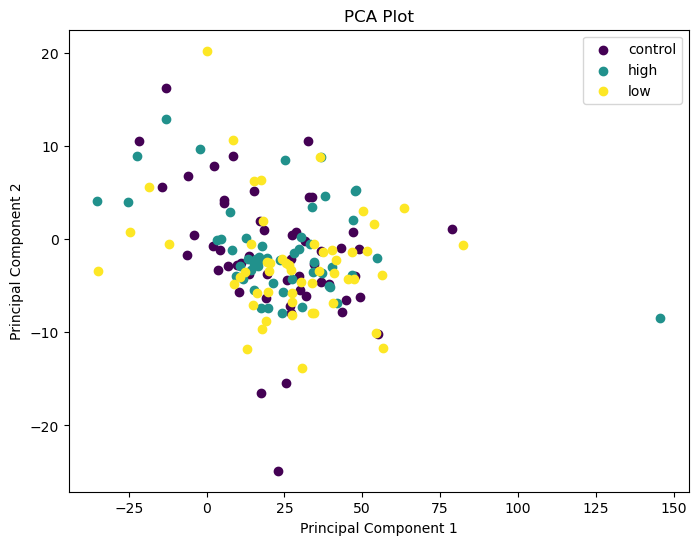

In [163]:
# Remove the first row (conditions) to get the gene expression data
gene_expression_data = genes.iloc[2:, 2:]

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(gene_expression_data)

# Create a DataFrame with the PCA results - 2 principal components
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Extract categories from column labels
categories = [col.split('.')[0] for col in gene_expression_data.columns]

# Map categories to colors
unique_categories = np.unique(categories)
num_categories = len(unique_categories)
color_map = plt.cm.get_cmap('viridis', num_categories)

# Plot PCA with colors based on doses
plt.figure(figsize=(8, 6))
for category, color in zip(unique_categories, color_map(np.linspace(0, 1, num_categories))):
    category_indices = [i for i, cat in enumerate(categories) if cat == category]
    plt.scatter(pca_df.loc[category_indices, 'PC1'], pca_df.loc[category_indices, 'PC2'], color=color, label=category)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot')
plt.legend()
plt.show()

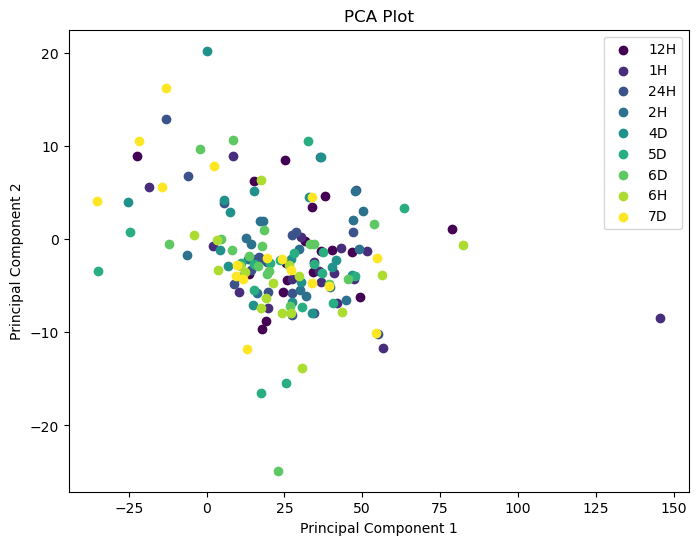

In [164]:
#Do the same thing but for timepoints
# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(gene_expression_data)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Extract timepoints from the first row
timepoints = genes.iloc[0, 2:]

# Map timepoints to colors
unique_timepoints = np.unique(timepoints)
num_timepoints = len(unique_timepoints)
color_map = plt.cm.get_cmap('viridis', num_timepoints)

# Plot PCA with colors based on timepoints
plt.figure(figsize=(8, 6))
for timepoint, color in zip(unique_timepoints, color_map(np.linspace(0, 1, num_timepoints))):
    timepoint_indices = [i for i, tp in enumerate(timepoints) if tp == timepoint]
    plt.scatter(pca_df.loc[timepoint_indices, 'PC1'], pca_df.loc[timepoint_indices, 'PC2'], color=color, label=timepoint)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot')
plt.legend()
plt.show()